In [0]:
!python3 -m pip install findspark

You are using pip version 19.0.3, however version 19.1.1 is available.
You should consider upgrading via the 'python -m pip install --upgrade pip' command.


In [0]:
import os
import matplotlib.pyplot as plt
%matplotlib inline

os.environ['SPARK_HOME'] = "C:\\Users\\raoti\\Downloads\\spark-2.4.3-bin-hadoop2.7\\spark-2.4.3-bin-hadoop2.7"
os.environ['HADOOP_HOME'] = "C:\\Users\\raoti\\Downloads\\spark-2.4.3-bin-hadoop2.7\\spark-2.4.3-bin-hadoop2.7\\bin"
print(os.getenv('SPARK_HOME'))

C:\Users\raoti\Downloads\spark-2.4.3-bin-hadoop2.7\spark-2.4.3-bin-hadoop2.7


In [0]:
import findspark
findspark.init()

In [0]:
#import findspark


# import pyspark 
# from pyspark.sql import SparkSession
# spark = SparkSession.builder.getOrCreate()

# df = spark.sql('''select 'spark' as hello ''')
# df.show()



In [0]:
# spark.stop()

In [0]:
from pyspark import SparkContext,SparkConf,SQLContext
from pyspark.sql.window import Window
import pyspark.sql.functions as func
from pyspark.sql.session import SparkSession

In [0]:
sconf = SparkConf()
sconf.setMaster('local')
sc = SparkContext() 
spark = SparkSession(sc)
sqlContext = SQLContext(sc)

In [0]:
train_file='C:\\Users\\raoti\\Documents\\NYU\\Classes\\Big Data\\project\\train.tsv'


df= sqlContext.read.format('com.databricks.spark.csv').options(header='true').option("delimiter", "\t").load(train_file)
# df = sqlContext.read.load(
#     location,
#     format = 'com.databricks.spark.csv',
#     header='false',
#     inferSchema=True)
print(df.columns)


['comment_text', 'target']


In [0]:
print((df.count(), len(df.columns)))

(50000, 2)


In [0]:
cols=['comment_text','target']
df=df[cols]
# df = df.toDF(*cols)


In [0]:
print(df.count())
print(df.columns)
print(df.select('comment_text').count())

50000
['comment_text', 'target']
50000


In [0]:
df.printSchema()

root
 |-- comment_text: string (nullable = true)
 |-- target: string (nullable = true)



In [0]:
df=df.dropna()

In [0]:
df.count()

50000

In [0]:
# df.show()

In [0]:
# df.select('target').distinct().show()

In [0]:
import pyspark.sql.functions as F
import pyspark.sql.types as T
from pyspark.sql.functions import udf

def categorize(col):
    print(col)
    tr = 1 if float(col) > 0.5 else 0
    return tr


my_udf = udf(categorize, T.StringType())

df_new = df.withColumn('targetBin', my_udf(df['target']))

In [0]:
# df_new.show()

In [0]:
df=df_new.drop('target')

In [0]:
# df=df.withColumnRenamed("target", "label")
df=df.withColumn("label1", df["targetBin"].cast("int"))

In [0]:
df.show()

+--------------------+-----+
|        comment_text|label|
+--------------------+-----+
|This is so cool. ...|    0|
|Thank you!! This ...|    0|
|This is such an u...|    0|
|Is this something...|    0|
|haha you guys are...|    1|
|ur a sh*tty comment.|    1|
|hahahahahahahahhh...|    0|
| FFFFUUUUUUUUUUUUUUU|    0|
|The ranchers seem...|    0|
|It was a great sh...|    0|
|Wow, that sounds ...|    0|
|"This is a great ...|    0|
|This seems like a...|    0|
|"It's ridiculous ...|    1|
|This story gets m...|    0|
|I agree; I don't ...|    0|
|Interesting. I'll...|    0|
|Awesome! I love C...|    0|
|"I'm glad you're ...|    0|
|"Angry trolls, mi...|    0|
+--------------------+-----+
only showing top 20 rows



In [0]:
df=df.drop('targetBin')

In [0]:
df=df.withColumnRenamed("label1", "label")

In [0]:
# df.show()

In [0]:
accuracies={}

In [0]:
from pyspark.ml.feature import RegexTokenizer, StopWordsRemover, CountVectorizer
from pyspark.ml.feature import Word2Vec
from pyspark.ml.classification import LogisticRegression

regexTokenizer = RegexTokenizer(inputCol="comment_text", outputCol="cleaned", pattern="\\W+",toLowercase=True)
stopwordsRemover = StopWordsRemover(inputCol="cleaned", outputCol="filtered")
countVectors = CountVectorizer(inputCol="filtered", outputCol="features", vocabSize=10000, minDF=5)
# word2Vec = Word2Vec(vectorSize=150, minCount=0, inputCol="filtered", outputCol="features")

In [0]:
from pyspark.ml import Pipeline

pipeline = Pipeline(stages=[regexTokenizer, stopwordsRemover, countVectors])
# pipeline = Pipeline(stages=[regexTokenizer, stopwordsRemover, word2Vec])

# Fitting pipeline to training documents.
pipelineFit = pipeline.fit(df)
dataset = pipelineFit.transform(df)

In [0]:
(trainingData, testData) = dataset.randomSplit([0.7, 0.3], seed = 100)
print("Training Dataset Count: " + str(trainingData.count()))
print("Test Dataset Count: " + str(testData.count()))

Training Dataset Count: 35119
Test Dataset Count: 14881


In [0]:
print(trainingData.columns)

['comment_text', 'label', 'cleaned', 'filtered', 'features']


In [0]:
# print(trainingData.select('features').count(),len(trainingData.select('features')))

In [0]:
lr = LogisticRegression(maxIter=20, regParam=0.3, elasticNetParam=0, family = "binomial")

# Training
lrModel = lr.fit(trainingData)

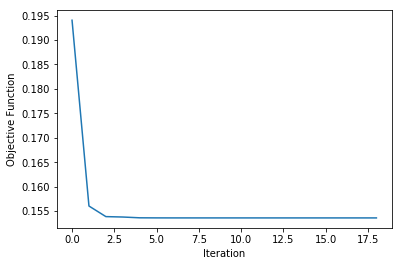

In [0]:


trainingSummary = lrModel.summary

# Objective per iteration
objectiveHistory = trainingSummary.objectiveHistory
plt.plot(objectiveHistory)
plt.ylabel('Objective Function')
plt.xlabel('Iteration')
plt.show()

In [0]:
print(trainingSummary.objectiveHistory)

[0.19405166149254954, 0.15603793755271078, 0.1538699927256011, 0.15378596231022643, 0.15362451533888558, 0.15360862828609018, 0.15360343519908012, 0.1536024777164918, 0.15360241229299926, 0.15360240004877107, 0.15360236123692603, 0.153602319791525, 0.1536022954055393, 0.1536022603581047, 0.1536022568912326, 0.15360225664496743, 0.15360225664054028, 0.15360225664042623, 0.1536022566403958]


In [0]:
predictions = lrModel.transform(testData)

predictions.select("comment_text","probability").show(n=10, truncate=40)

+----------------------------------------+----------------------------------------+
|                            comment_text|                             probability|
+----------------------------------------+----------------------------------------+
|""" It's as if Debbie Gibson had the ...|[0.9157812887416975,0.08421871125830252]|
|""" oh yeah, ferguson"". Where all th...|[0.9333628699308161,0.06663713006918402]|
|"""""""...There I found Captain J.K. ...|[0.9381415668365265,0.061858433163473...|
|"""""""On september 1st, 1853 I left ...|[0.9842784495015903,0.015721550498409...|
|""".... whose seemingly unstoppable r...|[0.9637217024884909,0.03627829751150915]|
|"""......less than $15/hr"".......Thi...|[0.9558098417469151,0.044190158253084...|
|""".....the release allowed folks inv...|[0.9660074108396679,0.03399258916033216]|
|"""....crime of conspiring to impede ...|[0.9916633204320128,0.008336679567987...|
|"""...and get into line with the lemm...|[0.9566394900780634,0.043360509921

In [0]:
predictions.filter(predictions['prediction'] == 0).select("comment_text","probability","label","prediction").orderBy("probability", ascending=False).show(n = 20, truncate = 30)

+------------------------------+------------------------------+-----+----------+
|                  comment_text|                   probability|label|prediction|
+------------------------------+------------------------------+-----+----------+
|I'm not a big fan of either...|[0.9981108624034938,0.00188...|    0|       0.0|
|Legislative Finance Directo...|[0.9972449844119523,0.00275...|    0|       0.0|
|Legislative Finance Directo...|[0.9972449844119523,0.00275...|    0|       0.0|
|Federal Child Safety Lock A...|[0.9970070946176336,0.00299...|    0|       0.0|
|"""Available"" and required...|[0.9970023964436411,0.00299...|    0|       0.0|
|Here you go..  “…banking, f...|[0.9968780761064091,0.00312...|    0|       0.0|
|"Greed = Hillary Clinton.  ...|[0.9967917162260787,0.00320...|    0|       0.0|
|"Part #2:  ...was more impo...|[0.9963637492166928,0.00363...|    0|       0.0|
|"By restricting your housin...|[0.9959766684886752,0.00402...|    0|       0.0|
|Life is a bell curve.  We b

In [0]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

evaluatorA = MulticlassClassificationEvaluator(metricName="accuracy")
acc=str(evaluatorA.evaluate(predictions, {evaluatorA.metricName: "accuracy"}))
print("Logistic Regression Test: Accuracy: " + acc)
accuracies['LR']=acc


Logistic Regression Test: Accuracy: 0.9506081580538942


In [0]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
print("Training: Area Under ROC: " + str(trainingSummary.areaUnderROC))

# Model Evaluation
evaluator = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction")
print("Test: Area Under ROC: " + str(evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})))

Training: Area Under ROC: 0.9786736966310631
Test: Area Under ROC: 0.9117702860888715


In [0]:
# predictions.select()

In [0]:
from pyspark.ml.classification import NaiveBayes

# Naive Bayes classifier
nb = NaiveBayes(smoothing=1, modelType="multinomial")

# train the model
nbmodel = nb.fit(trainingData)

In [0]:
# Prediction on Test Data
predictions_NB = nbmodel.transform(testData)
predictions_NB.filter(predictions_NB['prediction'] == 0).select("comment_text","probability","label","prediction").orderBy("probability", ascending=False).show(n = 20, truncate = 30)

# Accuracy on test set
evaluator = BinaryClassificationEvaluator(rawPredictionCol="prediction")
print("Test: Area Under ROC: " + str(evaluator.evaluate(predictions_NB, {evaluator.metricName: "areaUnderROC"})))

+------------------------------+----------------------------+-----+----------+
|                  comment_text|                 probability|label|prediction|
+------------------------------+----------------------------+-----+----------+
|By voting against the schoo...| [1.0,9.900780394491611E-17]|    0|       0.0|
|Time to pay the bills for a...| [1.0,9.570464968802051E-17]|    0|       0.0|
|Your specific claim is that...| [1.0,9.554182093380011E-17]|    0|       0.0|
|If you think oil companies ...| [1.0,9.520761812833445E-17]|    0|       0.0|
|From their own website:  Th...| [1.0,9.396237452933029E-17]|    0|       0.0|
|"Mr AK frost there is no fr...| [1.0,7.796543495712451E-17]|    0|       0.0|
|3. Any additional funds mad...| [1.0,7.502284417400892E-17]|    0|       0.0|
|The oil and gas industry ha...| [1.0,7.322751022658362E-17]|    0|       0.0|
|"Fair is an incredibly rela...| [1.0,6.948358564045826E-17]|    0|       0.0|
|Health insurance costs woul...|  [1.0,6.76354752310

In [0]:

evaluatorA = MulticlassClassificationEvaluator(metricName="accuracy")
# metrics = MulticlassMetrics(nbp)
# print(metrics.confusionMatrix().toArray())

In [0]:
testData.select('label').count()

14881

In [0]:
predictions_NB.columns

['comment_text',
 'label',
 'cleaned',
 'filtered',
 'features',
 'rawPrediction',
 'probability',
 'prediction']

In [0]:
acc=str(evaluatorA.evaluate(predictions_NB, {evaluatorA.metricName: "accuracy"}))
print("Naive Bayes Test: Accuracy: " + acc)
accuracies['NB']=acc

Naive Bayes Test: Accuracy: 0.9397889926752234


In [0]:
from pyspark.ml.classification import RandomForestClassifier

# initial RandomForest model.
rf = RandomForestClassifier(labelCol="label",featuresCol="features", numTrees = 50, maxDepth = 4, maxBins = 32)

# Train model with Training Data
rfModel = rf.fit(trainingData)

In [0]:
predictions_RF = rfModel.transform(testData)

predictions_RF.filter(predictions_RF['prediction'] == 0).select("comment_text","probability","label","prediction").orderBy("probability", ascending=False) \
    .show(n = 10, truncate = 30)

evaluator = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction")
print("Test: Area Under ROC: " + str(evaluator.evaluate(predictions_RF, {evaluator.metricName: "areaUnderROC"})))

+------------------------------+------------------------------+-----+----------+
|                  comment_text|                   probability|label|prediction|
+------------------------------+------------------------------+-----+----------+
|There are consequences for ...|[0.9545485523028272,0.04545...|    0|       0.0|
|"Typo correction is a trick...|[0.9543713293259551,0.04562...|    0|       0.0|
|Who didn't know that uber w...|[0.9542787576482816,0.04572...|    0|       0.0|
|"Wiles was completely on-po...|[0.9542787576482816,0.04572...|    0|       0.0|
|So why do I support Democra...|[0.9542787576482816,0.04572...|    0|       0.0|
|I agree with using PF earni...|[0.9542787576482816,0.04572...|    0|       0.0|
|Oh yea, there is plenty of ...|[0.9542787576482816,0.04572...|    0|       0.0|
|An income tax might - might...|[0.9542787576482816,0.04572...|    0|       0.0|
|"Tom Mitchell - so your alt...|[0.9542787576482816,0.04572...|    0|       0.0|
|Using the POMV as set forth

In [0]:

evaluatorA = MulticlassClassificationEvaluator(metricName="accuracy")
acc=str(evaluatorA.evaluate(predictions_RF, {evaluatorA.metricName: "accuracy"}))
print("Random Forest Test: Accuracy: " + acc)

accuracies['RF']=acc

Random Forest Test: Accuracy: 0.9491969625697197


In [0]:
from pyspark.ml.classification import GBTClassifier

# Train a GBT model.
gbt = GBTClassifier(labelCol="label", featuresCol="features", maxIter=10)

gbtmodel = gbt.fit(trainingData)

In [0]:
# Predictions
predictions_gbt = gbtmodel.transform(testData)

# test error
evaluator = BinaryClassificationEvaluator(labelCol="label",rawPredictionCol="prediction")
print("Test: Area Under ROC: " + str(evaluator.evaluate(predictions_gbt, {evaluator.metricName: "areaUnderROC"})))

Test: Area Under ROC: 0.6166517301119071


In [0]:

evaluatorA = MulticlassClassificationEvaluator(metricName="accuracy")
acc= str(evaluatorA.evaluate(predictions_gbt, {evaluatorA.metricName: "accuracy"}))
print("GBT Test: Accuracy: " +acc)

accuracies['GBT']=acc

GBT Test: Accuracy: 0.9579329346146093


In [0]:
from pyspark.ml.classification import LinearSVC
#Linear SVM model
lsvc = LinearSVC(maxIter=10, regParam=0.1)

lsvcModel = lsvc.fit(trainingData)


In [0]:
# Predictions
predictions_lvsc = lsvcModel.transform(testData)

# test error
evaluator = BinaryClassificationEvaluator(labelCol="label", rawPredictionCol="prediction")
print("Test: Area Under ROC: " + str(evaluator.evaluate(predictions_lvsc, {evaluator.metricName: "areaUnderROC"})))

Test: Area Under ROC: 0.6824241232382825


In [0]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

evaluatorA = MulticlassClassificationEvaluator(metricName="accuracy")
acc= str(evaluatorA.evaluate(predictions_lvsc, {evaluatorA.metricName: "accuracy"}))
print("SVM Test: Accuracy: " +acc)
accuracies['SVM']=acc

SVM Test: Accuracy: 0.9627713191317788


In [0]:
predictions_lr = lrModel.transform(trainingData)
predictions_nb = nbmodel.transform(trainingData)
predictions_rf = rfModel.transform(trainingData)
predictions_gbt = gbtmodel.transform(trainingData)
predictions_lsvc = lsvcModel.transform(trainingData)

predictions_lr = predictions_lr.withColumnRenamed("prediction", "pred_LR")
predictions_nb = predictions_nb.withColumnRenamed("prediction", "pred_NB")
predictions_rf = predictions_rf.withColumnRenamed("prediction", "pred_RF")
predictions_gbt = predictions_gbt.withColumnRenamed("prediction", "pred_GBT")
predictions_lsvc = predictions_lsvc.withColumnRenamed("prediction", "pred_LSVC")

In [0]:
tempA = predictions_lr.toPandas()[['label','pred_LR']].to_numpy()
temp_nb = predictions_nb.toPandas()[['pred_NB']].to_numpy()
temp_rf = predictions_rf.toPandas()[['pred_RF']].to_numpy()
temp_gbt = predictions_gbt.toPandas()[['pred_GBT']].to_numpy()
temp_lsvc = predictions_lsvc.toPandas()[['pred_LSVC']].to_numpy()

In [0]:
import numpy as np

tempA=np.append(tempA, temp_nb, 1)
tempA=np.append(tempA, temp_rf, 1)
tempA=np.append(tempA, temp_gbt, 1)
tempA=np.append(tempA, temp_lsvc, 1)

In [0]:
rdd1 = sc.parallelize(tempA)
rdd2 = rdd1.map(lambda x: [int(i) for i in x])
train_df = rdd2.toDF(["label", "pred_LR","pred_NB","pred_RF","pred_GBT","pred_LSVC"])
train_df.count()

35119

In [0]:
train_df.show()

In [0]:
predictions_lr = lrModel.transform(testData)
predictions_nb = nbmodel.transform(testData)
predictions_rf = rfModel.transform(testData)
predictions_gbt = gbtmodel.transform(testData)
predictions_lsvc = lsvcModel.transform(testData)

predictions_lr = predictions_lr.withColumnRenamed("prediction", "pred_LR")
predictions_nb = predictions_nb.withColumnRenamed("prediction", "pred_NB")
predictions_rf = predictions_rf.withColumnRenamed("prediction", "pred_RF")
predictions_gbt = predictions_gbt.withColumnRenamed("prediction", "pred_GBT")
predictions_lsvc = predictions_lsvc.withColumnRenamed("prediction", "pred_LSVC")

tempA = predictions_lr.toPandas()[['label','pred_LR']].to_numpy()
temp_nb = predictions_nb.toPandas()[['pred_NB']].to_numpy()
temp_rf = predictions_rf.toPandas()[['pred_RF']].to_numpy()
temp_gbt = predictions_gbt.toPandas()[['pred_GBT']].to_numpy()
temp_lsvc = predictions_lsvc.toPandas()[['pred_LSVC']].to_numpy()


tempA=np.append(tempA, temp_nb, 1)
tempA=np.append(tempA, temp_rf, 1)
tempA=np.append(tempA, temp_gbt, 1)
tempA=np.append(tempA, temp_lsvc, 1)

rdd1 = sc.parallelize(tempA)
rdd2 = rdd1.map(lambda x: [int(i) for i in x])
test_df = rdd2.toDF(["label", "pred_LR","pred_NB","pred_RF","pred_GBT","pred_LSVC"])
test_df.count()

14881

In [0]:
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler

assembler = VectorAssembler(
    inputCols=["pred_LR","pred_NB","pred_RF","pred_GBT","pred_LSVC"],
    outputCol="features")

metaTrData = assembler.transform(train_df)
metaTsData = assembler.transform(test_df)
# metaTrData = metaTrData.withColumn('label',df['label'])

In [0]:
#Meta Learner
metalr = LogisticRegression(maxIter=20, regParam=0.3, elasticNetParam=0.8, family = "binomial")

# Training
metalrModel = metalr.fit(metaTrData)

In [0]:
# Predictions
predictions_meta = metalrModel.transform(metaTsData)

# test error
evaluator = BinaryClassificationEvaluator(labelCol="label", rawPredictionCol="prediction")
print("Test: Area Under ROC: " + str(evaluator.evaluate(predictions_meta, {evaluator.metricName: "areaUnderROC"})))

Test: Area Under ROC: 0.5


In [0]:
predictions_meta.count()

14881

In [0]:
evaluatorA = MulticlassClassificationEvaluator(metricName="accuracy")
acc=str(evaluatorA.evaluate(predictions_meta, {evaluatorA.metricName: "accuracy"}))
print("Meta Learner Test: Accuracy: " + str(evaluatorA.evaluate(predictions_meta, {evaluatorA.metricName: "accuracy"})))
accuracies['Meta']=acc

Meta Learner Test: Accuracy: 0.9491969625697197


In [0]:
# metaTrData.write.parquet('C:\\Users\\raoti\\Documents\\NYU\\Classes\\Big Data\\project\\metaInputTr')
# metaTsData.write.parquet('C:\\Users\\raoti\\Documents\\NYU\\Classes\\Big Data\\project\\metaInputTs')

In [0]:
# savetrain= metaTrData.toPandas()
# savetest= metaTsData.toPandas()

In [0]:
metaTrData.columns

['label', 'pred_LR', 'pred_NB', 'pred_RF', 'pred_GBT', 'pred_LSVC', 'features']

In [0]:
# savetrain.to_csv("C:\\Users\\raoti\\Documents\\NYU\\Classes\\Big Data\\project\\metaInputTr_sample.tsv",sep='\t',index=False)
# savetest.to_csv("C:\\Users\\raoti\\Documents\\NYU\\Classes\\Big Data\\project\\metaInputTs_sample.tsv",sep='\t',index=False)

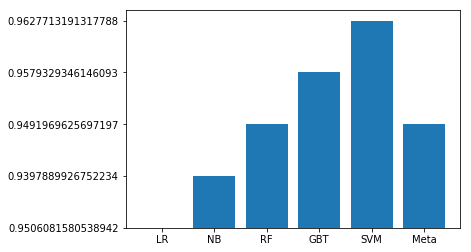

In [0]:
import matplotlib.pyplot as plt


plt.bar(range(len(accuracies)), list(accuracies.values()), align='center')
plt.xticks(range(len(accuracies)), list(accuracies.keys()))
# # for python 2.x:
# plt.bar(range(len(D)), D.values(), align='center')  # python 2.x
# plt.xticks(range(len(D)), D.keys())  # in python 2.x

plt.show()